In [16]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
import xgboost as xgb

In [7]:
# Load the data
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

In [8]:
# Data preprocessing and feature engineering
def preprocess_data(df):
    # Extract group and passenger number from PassengerId
    df[['Group', 'PassengerNo']] = df['PassengerId'].str.split('_', expand=True)
        
    # Extract deck, cabin number, and side from Cabin
    df[['Deck', 'CabinNo', 'Side']] = df['Cabin'].str.split('/', expand=True)
    
    # Impute missing values
    numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    categorical_features = ['HomePlanet', 'Destination', 'Group', 'Deck', 'Side', 'Name']
    boolean_features = ['CryoSleep', 'VIP']
    
    for feature in numerical_features:
        df[feature] = df[feature].fillna(df[feature].median())
    
    for feature in categorical_features:
        df[feature] = df[feature].fillna(df[feature].mode().iloc[0])
    
    # Label encode categorical features
    le = LabelEncoder()
    for feature in categorical_features:
        df[feature] = le.fit_transform(df[feature])
     # Standardize numerical features
    scaler = StandardScaler()
    df[numerical_features] = scaler.fit_transform(df[numerical_features])
    
    # Encode boolean features as integers
    for feature in boolean_features:
        df[feature].fillna(False, inplace=True)
        df[feature] = df[feature].astype(int)
    
    # Drop unnecessary columns
    df.drop(['PassengerId', 'Cabin', 'CabinNo', 'PassengerNo'], axis=1, inplace=True)
    
    return df

In [9]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Split the data into training and validation sets
X = train_data.drop('Transported', axis=1)
y = train_data['Transported']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# Model training and hyperparameter tuning
params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

model = xgb.XGBClassifier(random_state=42, objective='binary:logistic', n_jobs=-1, eval_metric='auc')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(estimator=model, param_grid=params, scoring='f1', cv=skf, verbose=2, n_jobs=-1)

grid.fit(X_train, y_train)
best_params = grid.best_params_

# Train the final model with the best parameters
final_model = xgb.XGBClassifier(**best_params, random_state=42, objective='binary:logistic', n_jobs=-1, eval_metric='auc')
final_model.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [11]:
# Validate the model
y_pred_val = final_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val)
print(f'Validation accuracy: {val_accuracy:.4f}')
print(f'Validation F1 score: {val_f1:.4f}')

Validation accuracy: 0.8051
Validation F1 score: 0.8077


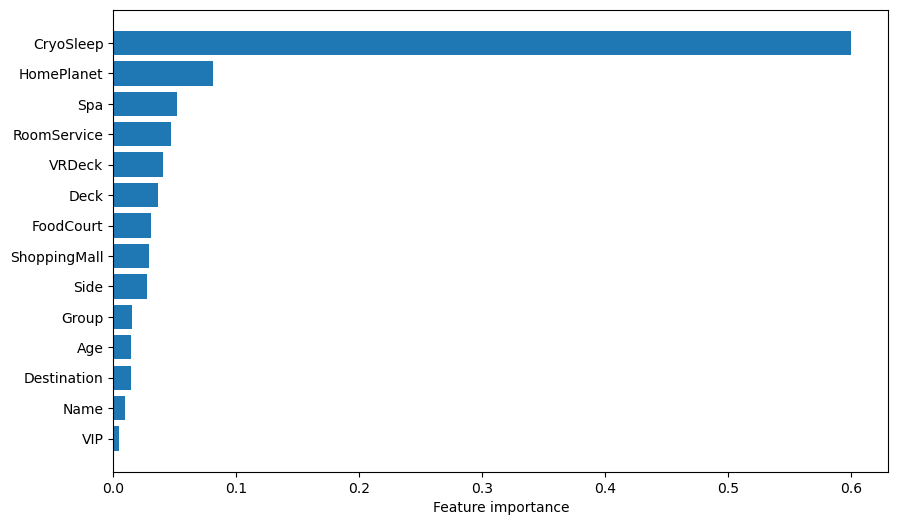

In [12]:
# Feature importance
feature_importances = final_model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel('Feature importance')
plt.show()

In [13]:
# Predict on the test set
X_test = test_data
y_pred_test = final_model.predict(X_test)

In [15]:
# Prepare the submission file
submission = pd.read_csv('./sample_submission.csv')
submission['Transported'] = y_pred_test.astype(bool)
submission.to_csv('submission.csv', index=False)
print('Submission file created.')

Submission file created.


<b>MODEL 2</b>

In [18]:
# Separate features and target variable
X_train = train.drop(["Transported"], axis=1)
y_train = train["Transported"]

# Fit the decision tree model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test data
X_test = test_df.drop(["PassengerId"], axis=1)
y_pred = clf.predict(X_test)

# Generate submission file
submission_df = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Transported": y_pred})
submission_df.to_csv("submission2.csv", index=False)

NameError: name 'train' is not defined

<large><b>MODEL 3</b></large>

In [19]:
# Load the data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Separate features and target variable
X_train = train_df.drop(["Transported"], axis=1)
y_train = train_df["Transported"]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test_df.drop(["PassengerId"], axis=1))

# Fit the SVM model
clf = SVC(kernel="rbf", C=10, gamma=0.1, random_state=42)
clf.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test_scaled)

# Generate submission file
submission_df = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Transported": y_pred})
submission_df.to_csv("submission3.csv", index=False)

ValueError: could not convert string to float: 'Europa'